In [1]:
%matplotlib notebook

# Current status and things to do
#----------------------------------
# 1) Feedback - See how to deal with this, state estimator
# 2) Disturbances - State estimator
# 3) Soft contstraints on CVs
# 4) make it nicer to run in a loop - (Models from other function/text file, Controller Tuning, Initialisation -> Check XML read)

import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib
from cvxopt import solvers
from cvxopt.solvers import qp
from cvxopt import matrix

# controller classes
import Model as LTImodel # dynamic models
import InitCond as initial # init conditions for controller
import tuning as tune # tuning matrices for controller
import ContRanges as c_ranges # tuning matrices for controller
import MPCcontroller as MPC # MPC controller
import StatePredictor as StatePred # state predictor

# Tools
import CommonUtils as Tools # some tools to make handling things easier

# Testing
from StatePredictor import shift_Yhat as my
import time as clock

# to be removed
import scipy.signal as sig

In [2]:
# Create the model
no_mvs = 3
no_cvs = 2
no_dvs = 1

# Model
G = matlib.repmat(None, no_cvs, no_mvs + no_dvs)

G[0][0] = sig.lti([1.0], [10.0, 1.0])
G[0][1] = sig.lti([-0.01], [1.0, 0.0])
G[0][2] = sig.lti([-0.3], [3.0, 1.0, 0.1])

G[1][0] = sig.lti([-1.0], [5.0, 1.7, 1.0])
G[1][1] = sig.lti([1.0], [5.0, 1.0])
G[1][2] = sig.lti([0.5], [13.0, 3.1, 1.0])

# Disturbance
G[0][3] = sig.lti([-0.5], [10.0, 1.0])
G[1][3] = sig.lti([0.1, 0.3], [30.0, 20, 1.0])

# Create the model object
pred_H = 30
deltaT = 2
G_model = LTImodel.Mod(G, deltaT, pred_H)

<IPython.core.display.Javascript object>


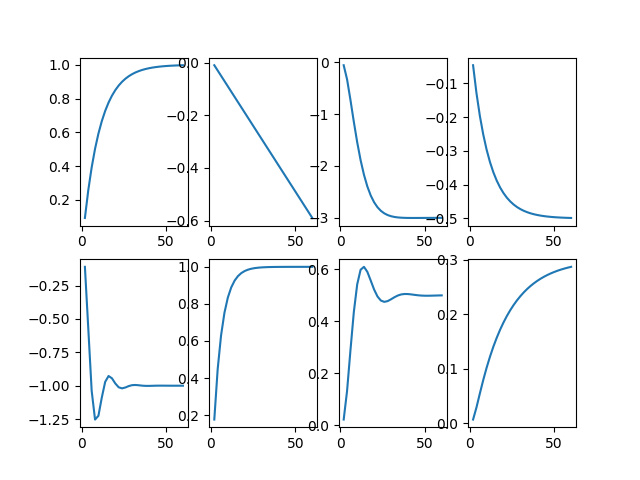

In [3]:
# Plot stepresponse
G_model.plot_stepresponse()

In [5]:
# Define inputs
sim_time = 100

# u is random
plant_u = np.random.rand( sim_time, no_mvs)
plant_u[0,:] = 0

# d is random
plant_d = np.random.rand( sim_time, no_dvs)
plant_d[0,:] = 0

time, plant_y = G_model.simulate( np.concatenate( [ plant_u, plant_d ], axis=1 ))

<IPython.core.display.Javascript object>


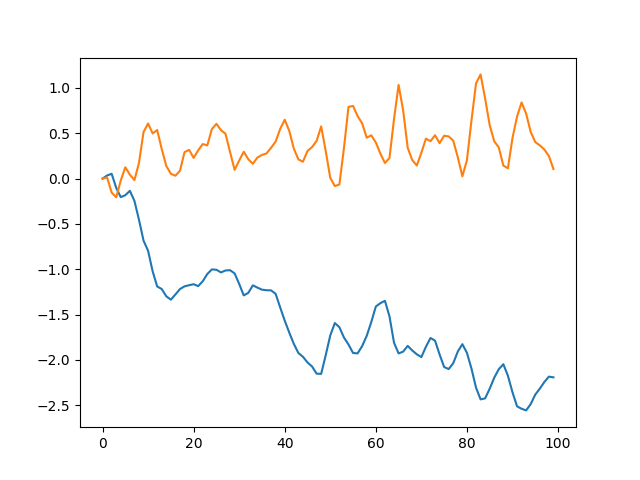

In [6]:
plt.plot(plant_y)

In [7]:
# state predictor config
init_PV = np.zeros(no_cvs)
init_MV = np.zeros(no_mvs + no_dvs)

init_state = Tools.vector_appending(init_PV, pred_H)
State = StatePred.Predictor(G_model, deltaT,  pred_H, 1, init_state)

array([ 0.,  0.,  0.,  0.])

<IPython.core.display.Javascript object>


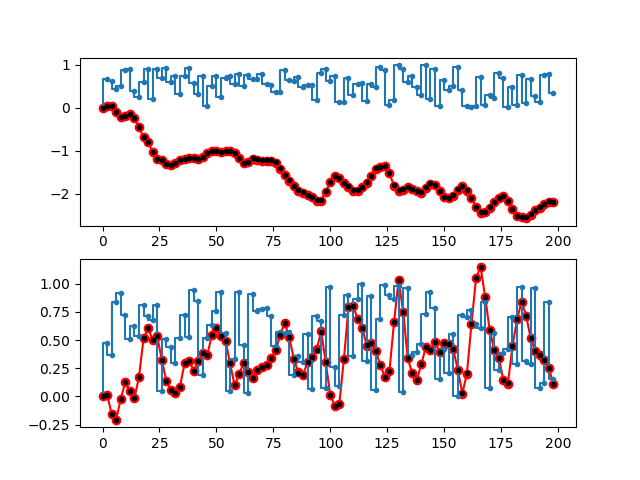

In [23]:
# Run Simulation - SPECIFIC To a 2 CV case
plt.subplot(211)
plt.plot(time, plant_y[:,0], 'ro-')
plt.step(time, plant_u[:,0], '.-')
    
plt.subplot(212)
plt.plot(time, plant_y[:,1], 'ro-')
plt.step(time, plant_u[:,1], '.-')

prev_u = init_MV[0:no_mvs]
prev_d = init_MV[no_mvs:]

for i in range(0,sim_time):
    # Plot
    y_s1 = State.update_state(plant_y[i], np.concatenate([plant_u[i,:] , plant_d[i,:]]) - np.concatenate([prev_u, prev_d]))
    prev_u = plant_u[i,:]
    prev_d = plant_d[i]
    plt.subplot(211)
    plt.plot(2*i, y_s1[0],'k.-')

    plt.subplot(212)
    plt.plot(2*i, y_s1[pred_H],'k.-')
    #print(State.error)

In [ ]:
np.shape(State.Gd_Su)